In [63]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("gabrielmanfredi/football-players-ratings")
#print("Path to dataset files:", path)

# Importation des packages et du Dataset

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.feature_selection import mutual_info_regression

In [65]:
df = pd.read_csv('data_football_ratings.csv')

# Découverte du Dataset

# Statistiques descriptives

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64  
 14  shotsblocked            50652 non-null

In [86]:
df.columns

Index(['competition', 'team', 'pos', 'pos_role', 'player', 'rater', 'is_human',
       'original_rating', 'goals', 'assists',
       ...
       'pos_role_Sub', 'rater_Bild', 'rater_Kicker', 'rater_SkySports',
       'rater_SofaScore', 'rater_TheGuardian', 'rater_WhoScored',
       'higher_rater', 'Substitute', 'nombre_apparitions'],
      dtype='object', length=265)

In [67]:
def extract_opponent_and_scores(match_str, team):
    """
    Returns (opp_team, team_score, opp_score).
    - match_str : "France - Romania, 2 - 1"
    - team      : name of the team (e.g., "France" or "Romania")
    """
    pattern = re.compile(r"^([^-]+)\s*-\s*([^,]+),\s*(\d+)\s*-\s*(\d+)$")
    match = pattern.match(match_str)
    if match:
        team1 = match.group(1).strip()
        team2 = match.group(2).strip()
        score1 = int(match.group(3))
        score2 = int(match.group(4))

        if team == team1:
            return (team2, score1, score2)
        elif team == team2:
            return (team1, score2, score1)
        else:
            return (None, None, None)
    else:
        return (None, None, None)

# Create new columns with the extracted infos
df['opp_team'], df['team_score'], df['opp_score'] = zip(*df.apply(
    lambda row: extract_opponent_and_scores(row['match'], row['team']), axis=1
))

df[['match', 'team', 'opp_team', 'team_score', 'opp_score']].head()

,match,team,opp_team,team_score,opp_score
0,"France - Romania, 2 - 1",Romania,France,1,2
1,"France - Romania, 2 - 1",Romania,France,1,2
2,"France - Romania, 2 - 1",Romania,France,1,2
3,"France - Romania, 2 - 1",France,Romania,2,1
4,"France - Romania, 2 - 1",Romania,France,1,2


In [68]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Extraire l'année et le semestre

df['year'] = df['date'].dt.year
df['semester'] = (df['date'].dt.month // 3) + (df['date'].dt.month % 3 > 0)

df[['date', 'year', 'semester']].head()

,date,year,semester
0,2016-06-10,2016,2
1,2016-06-10,2016,2
2,2016-06-10,2016,2
3,2016-06-10,2016,2
4,2016-06-10,2016,2


In [69]:
columns_to_dummies = ['team', 'opp_team', 'competition', 'pos', 'pos_role', 'rater']

# Création des dummies sans supprimer les colonnes originales
get_dum = pd.get_dummies(df[columns_to_dummies], prefix=columns_to_dummies)

# Ajout des dummies au DataFrame sans dupliquer les colonnes originales
df = pd.concat([df, get_dum], axis=1)


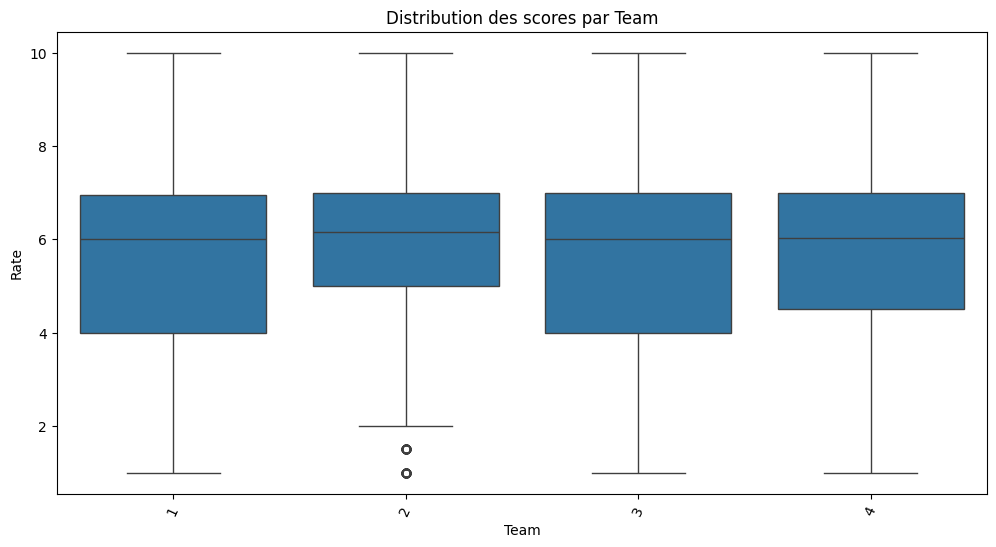

In [70]:
# Tracer les boxplots pour chaque team
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='semester', y='original_rating')
plt.title('Distribution des scores par Team')
plt.xlabel('Team')
plt.ylabel('Rate')
plt.xticks(rotation=65)
plt.show()

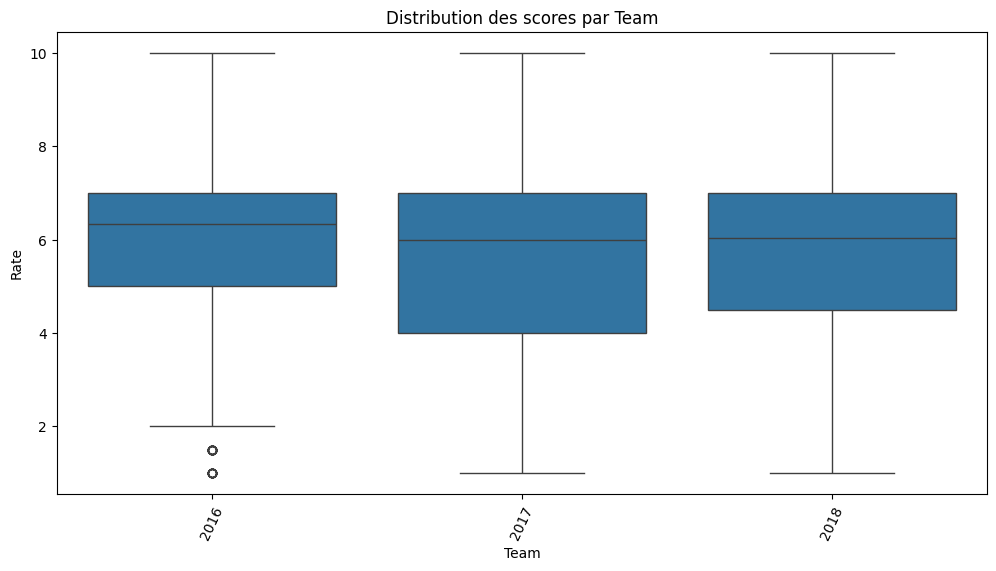

In [71]:
# Tracer les boxplots pour chaque team
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='year', y='original_rating')
plt.title('Distribution des scores par Team')
plt.xlabel('Team')
plt.ylabel('Rate')
plt.xticks(rotation=65)
plt.show()

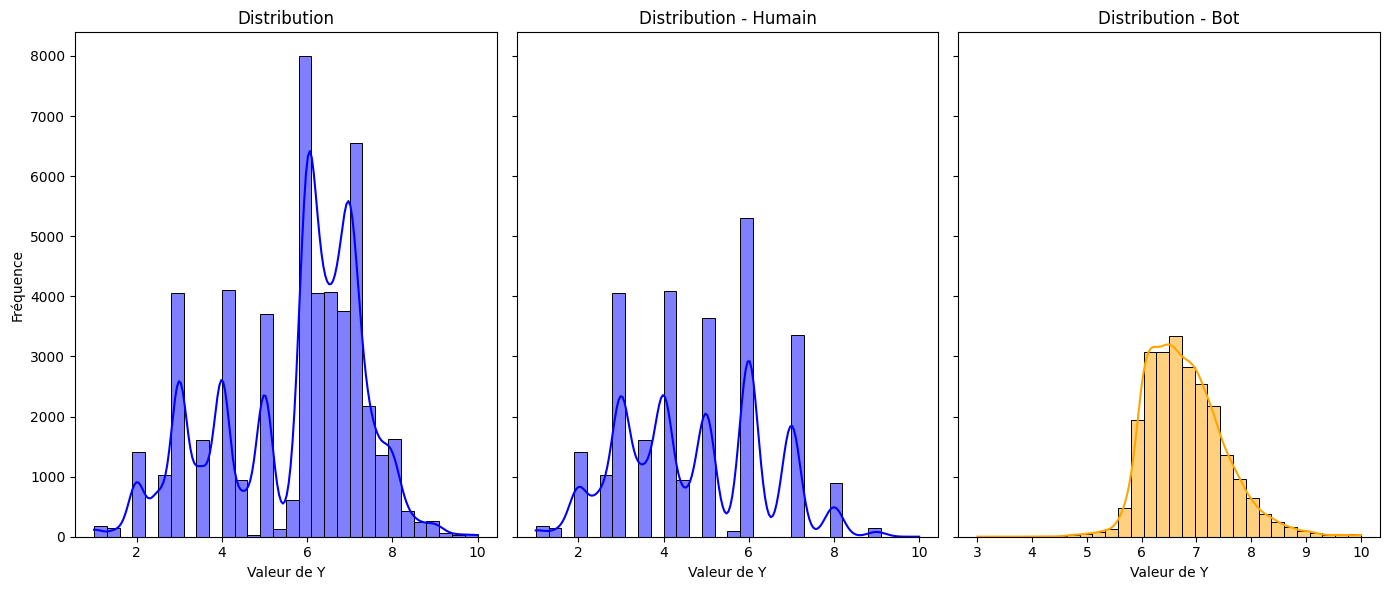

In [72]:
df_human = df[df['is_human']==1]
df_bot = df[df['is_human']==0]

# Créer un subplot avec deux graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

# Distribution des humains
sns.histplot(df['original_rating'], kde=True, bins=30, ax=axes[0], color='blue')
axes[0].set_title("Distribution")
axes[0].set_xlabel("Valeur de Y")
axes[0].set_ylabel("Fréquence")

# Distribution des humains
sns.histplot(df_human['original_rating'], kde=True, bins=30, ax=axes[1], color='blue')
axes[1].set_title("Distribution - Humain")
axes[1].set_xlabel("Valeur de Y")
axes[1].set_ylabel("Fréquence")

# Distribution des bots
sns.histplot(df_bot['original_rating'], kde=True, bins=30, ax=axes[2], color='orange')
axes[2].set_title("Distribution - Bot")
axes[2].set_xlabel("Valeur de Y")
axes[2].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

Il est intéressant d'observer que les bots ont tendances à attribuer des notes élevées avec une distribution en cloche et avec peu de disparitées (s'expliquant par un éventuel biais auto entretenu?) tandis la notation humaine contient plus de disparité et est souvent discrète.

**Lien entre Team et journal de notation ?**

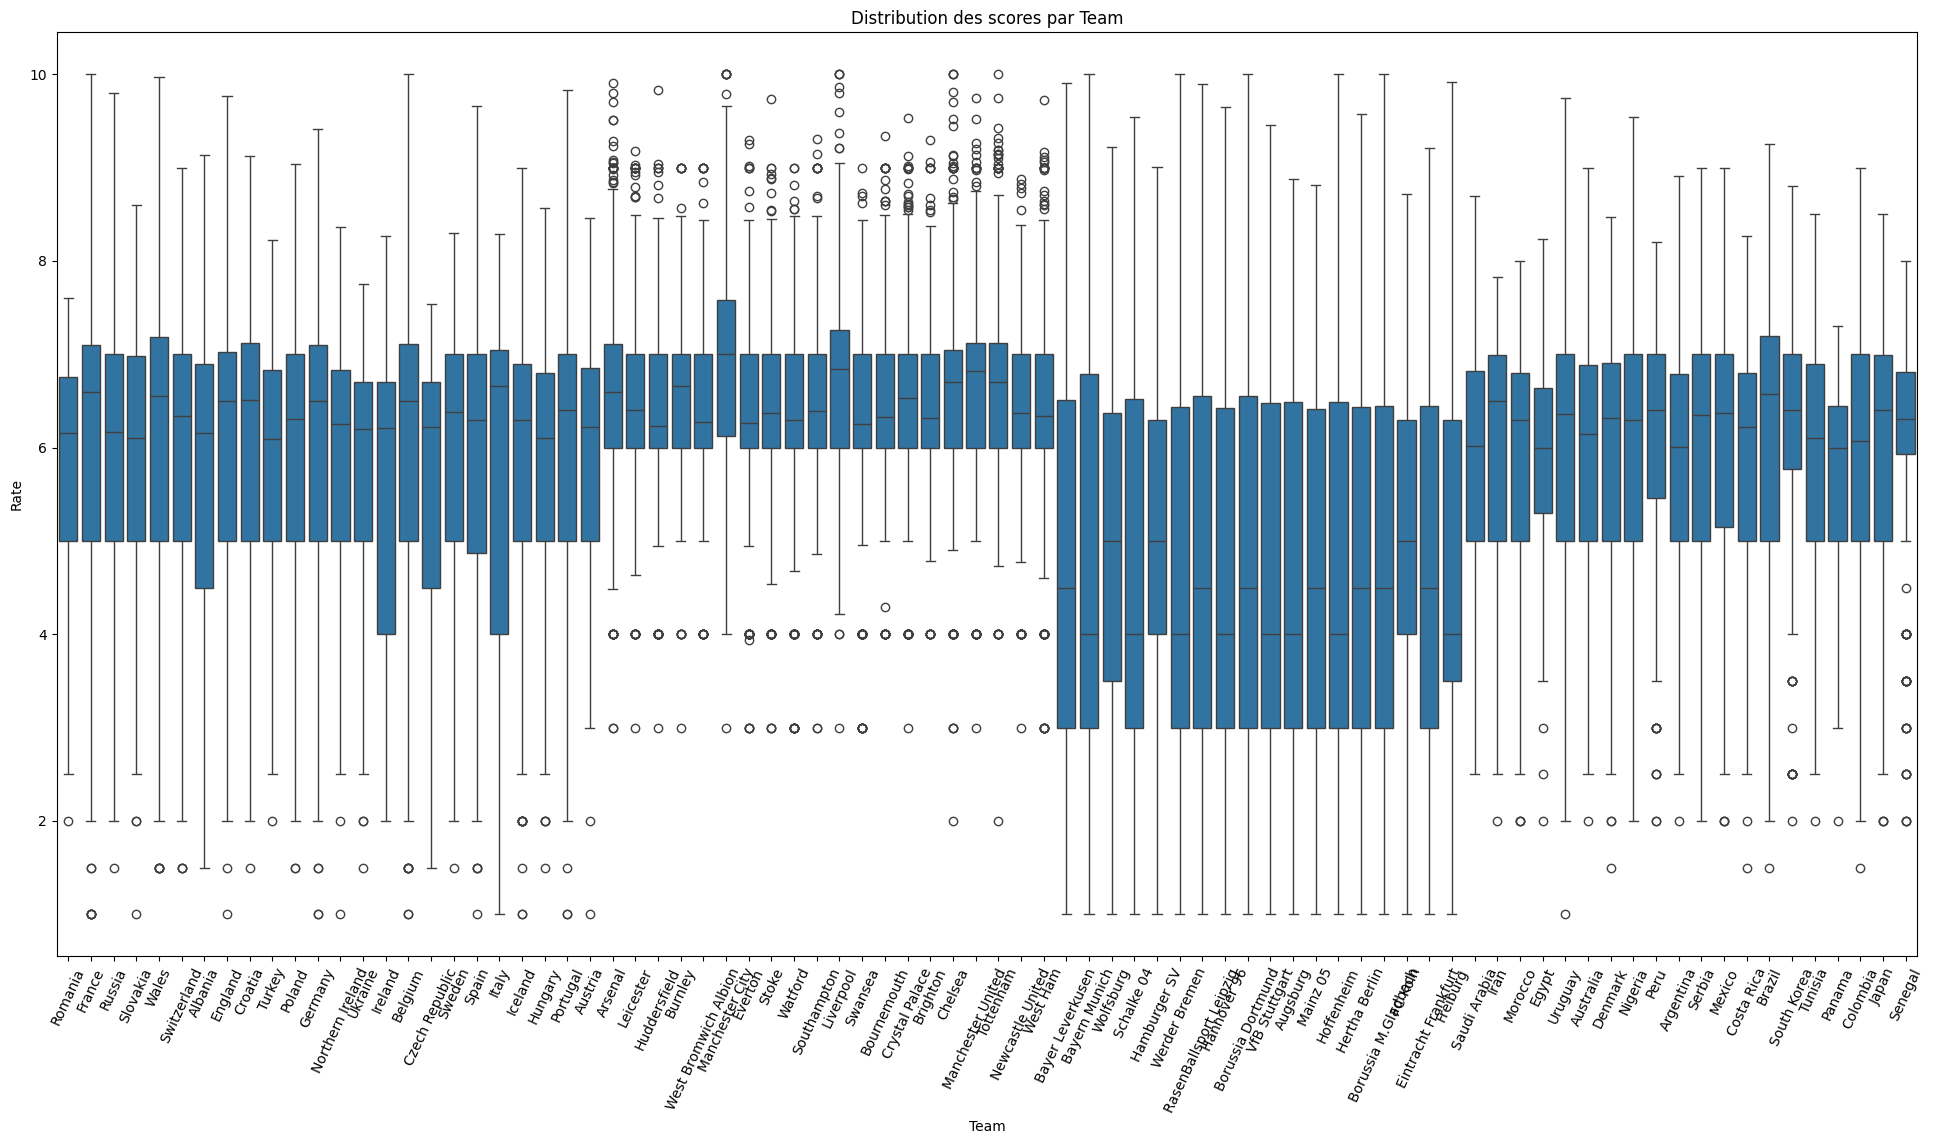

In [73]:
# Tracer les boxplots pour chaque team
plt.figure(figsize=(24, 12))
sns.boxplot(data=df, x='team', y='original_rating')
plt.title('Distribution des scores par Team')
plt.xlabel('Team')
plt.ylabel('Rate')
plt.xticks(rotation=65)
plt.show()

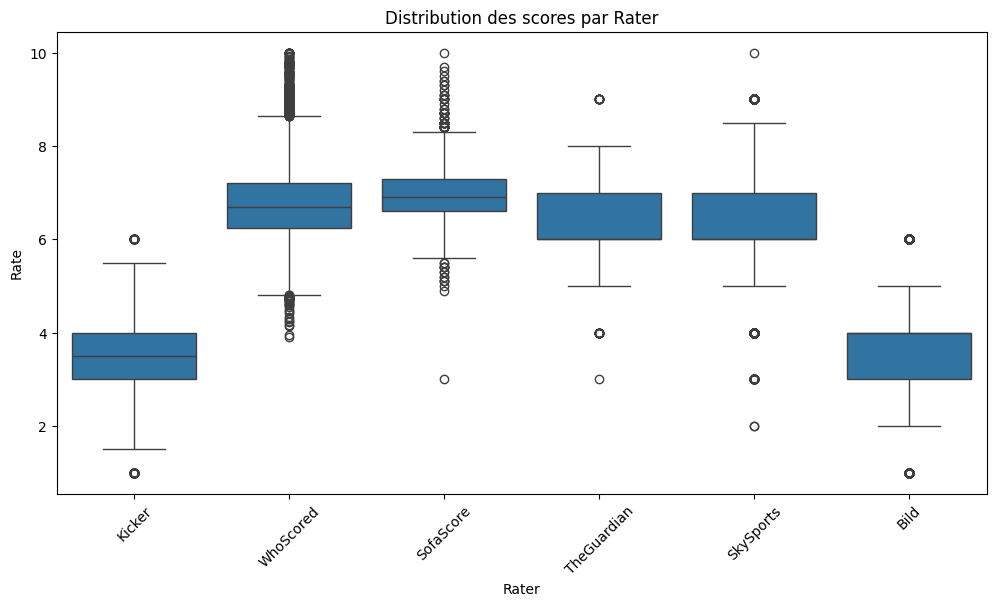

In [74]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rater', y='original_rating')
plt.title('Distribution des scores par Rater')
plt.xlabel('Rater')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

In [75]:
# Création de la variable higher_rater : 1 si rater est dans la liste donnée, 0 sinon
liste_raters = ['WhoScored', 'SofaScore', 'TheGuardian', 'SkySports']
df['higher_rater'] = np.where(df['rater'].isin(liste_raters), 1, 0)

Il est intéressant d'observer qu'il existent des disparitées importantes entre les évaluateurs. Nous pouvons distinguer deux groupes.

**Creation des dummies**

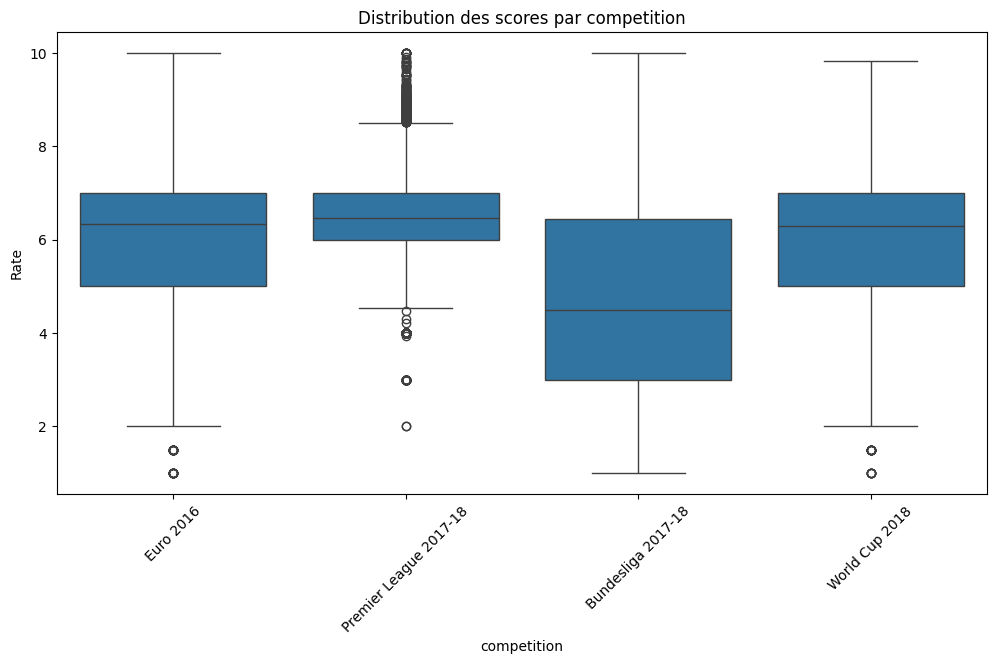

In [76]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='competition', y='original_rating')
plt.title('Distribution des scores par competition')
plt.xlabel('competition')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

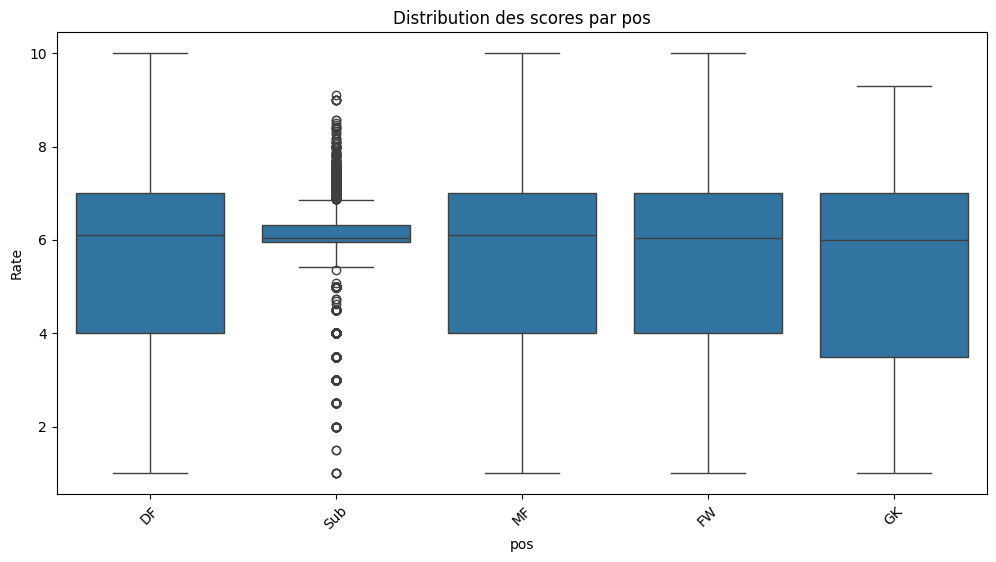

In [77]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='pos', y='original_rating')
plt.title('Distribution des scores par pos')
plt.xlabel('pos')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

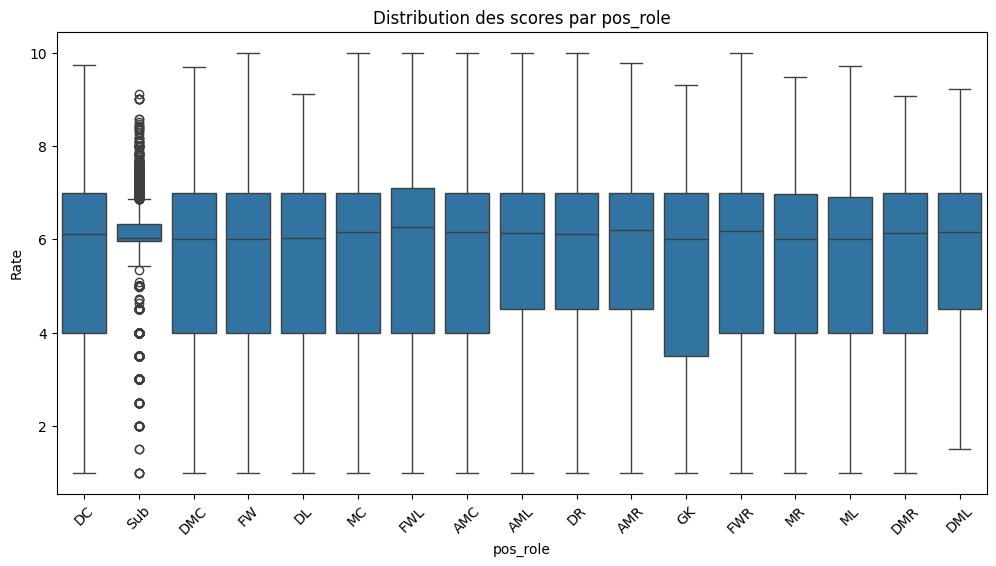

In [78]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='pos_role', y='original_rating')
plt.title('Distribution des scores par pos_role')
plt.xlabel('pos_role')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

In [79]:
# Création de la variable Substitute : 1 si Substitute est dans la liste donnée, 0 sinon
df['Substitute'] = np.where(df['pos_role'].isin(['Sub']), 1, 0)

In [80]:
df

,competition,date,match,team,pos,pos_role,player,rater,is_human,original_rating,...,pos_role_MR,pos_role_Sub,rater_Bild,rater_Kicker,rater_SkySports,rater_SofaScore,rater_TheGuardian,rater_WhoScored,higher_rater,Substitute
0,Euro 2016,2016-06-10,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,Kicker,1,3.50,...,False,False,False,True,False,False,False,False,0,0
1,Euro 2016,2016-06-10,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,WhoScored,0,6.56,...,False,False,False,False,False,False,False,True,1,0
2,Euro 2016,2016-06-10,"France - Romania, 2 - 1",Romania,DF,DC,Dragos Grigore,SofaScore,0,6.70,...,False,False,False,False,False,True,False,False,1,0
3,Euro 2016,2016-06-10,"France - Romania, 2 - 1",France,Sub,Sub,Anthony Martial,WhoScored,0,6.19,...,False,True,False,False,False,False,False,True,1,1
4,Euro 2016,2016-06-10,"France - Romania, 2 - 1",Romania,MF,DMC,Mihai Pintilii,Kicker,1,3.50,...,False,False,False,True,False,False,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50647,World Cup 2018,2018-07-15,"France - Croatia, 4 - 2",Croatia,MF,ML,Ivan Perisic,SkySports,1,8.00,...,False,False,False,False,True,False,False,False,1,0
50648,World Cup 2018,2018-07-15,"France - Croatia, 4 - 2",Croatia,MF,ML,Ivan Perisic,WhoScored,0,6.89,...,False,False,False,False,False,False,False,True,1,0
50649,World Cup 2018,2018-07-15,"France - Croatia, 4 - 2",Croatia,MF,ML,Ivan Perisic,SofaScore,0,6.40,...,False,False,False,False,False,True,False,False,1,0
50650,World Cup 2018,2018-07-15,"France - Croatia, 4 - 2",Croatia,Sub,Sub,Marko Pjaca,SkySports,1,6.00,...,False,True,False,False,True,False,False,False,1,1


In [81]:
# Nous créons une colonne qui permet de vérifier le nombre d'occurence par joueur
# Cette variable permettra de rendre non sensible nos prédictions à la moyenne car si le joueur apparait une fois il a possibilité d'afficher des performances élevées par chance contrairement aux joueurs jouant plus souvent. Le nombre de fois où un joueur joue peut être signe de bonne perf.

df['nombre_apparitions'] = df['player'].map(df['player'].value_counts())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


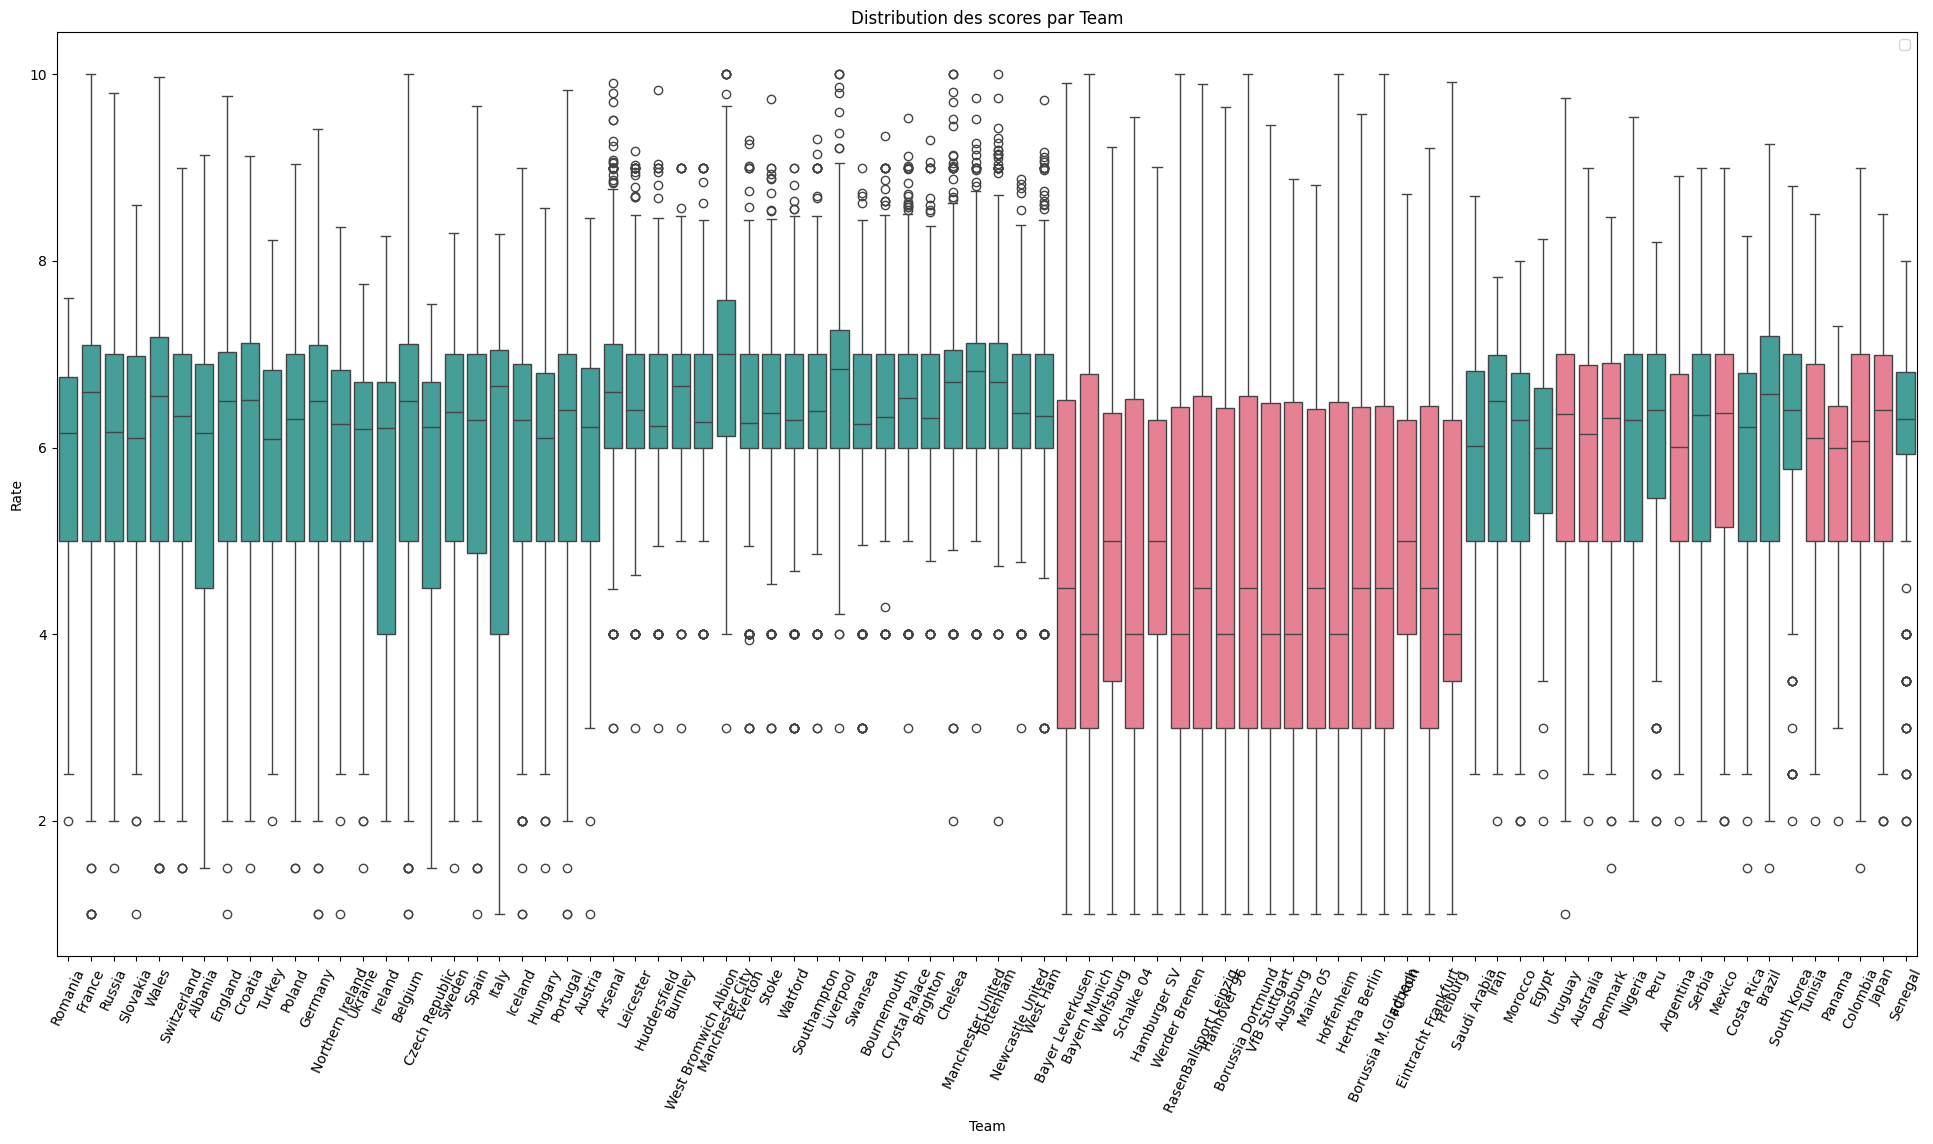

In [82]:
# Générer un dictionnaire de couleurs unique pour chaque journal
unique_journals = df['is_human'].unique()
palette = sns.color_palette("husl", len(unique_journals))
journal_colors = {journal: palette[i] for i, journal in enumerate(unique_journals)}

# Déterminer le journal majoritaire pour chaque team
team_major_journal = df.groupby('team')['is_human'].agg(lambda x: x.value_counts().idxmax())

# Associer une couleur unique à chaque team en fonction du journal majoritaire
team_colors = {team: journal_colors[team_major_journal[team]] for team in df['team'].unique()}

# Tracer les boxplots pour chaque team avec les couleurs correspondantes
plt.figure(figsize=(24, 12))
sns.boxplot(data=df, x='team', y='original_rating', hue='team', palette=team_colors, dodge=False)
plt.title('Distribution des scores par Team')
plt.xlabel('Team')
plt.ylabel('Rate')
plt.xticks(rotation=65)
plt.legend()
plt.show()

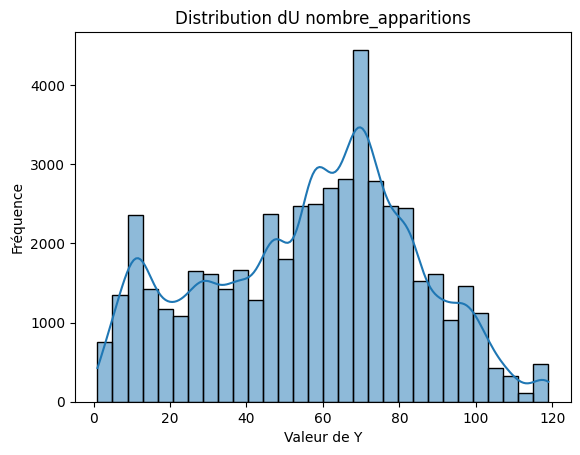

In [83]:
sns.histplot(df['nombre_apparitions'], kde=True, bins=30)
plt.title("Distribution dU nombre_apparitions")
plt.xlabel("Valeur de Y")
plt.ylabel("Fréquence")
plt.show()

Nous pouvons voir effectivement qu'il y a beaucoup de disparité et qu'il est nécessaire que l'algorithme de prédiction utilisé prennent en compte cette variabilité pour ne pas pénaliser la note prédite d'un joueur qui joue fréquemment.

In [85]:
df = df.drop(columns=['date', 'match'])

In [ ]:
df_avg = df.groupby('player', as_index=False).mean()
df_med = df.groupby('player', as_index=False).median()
print("Nous travaillerons donc avec", len(df_avg), "joueurs")

Nous travaillerons donc avec 1632 joueurs


In [87]:
df.to_csv('football_ratings_cleaned.csv')
#df_avg.to_csv('avg_football_ratings_cleaned.csv')
#df_med.to_csv('med_football_ratings_cleaned.csv')

In [ ]:
e'('')'''

# Corrélations

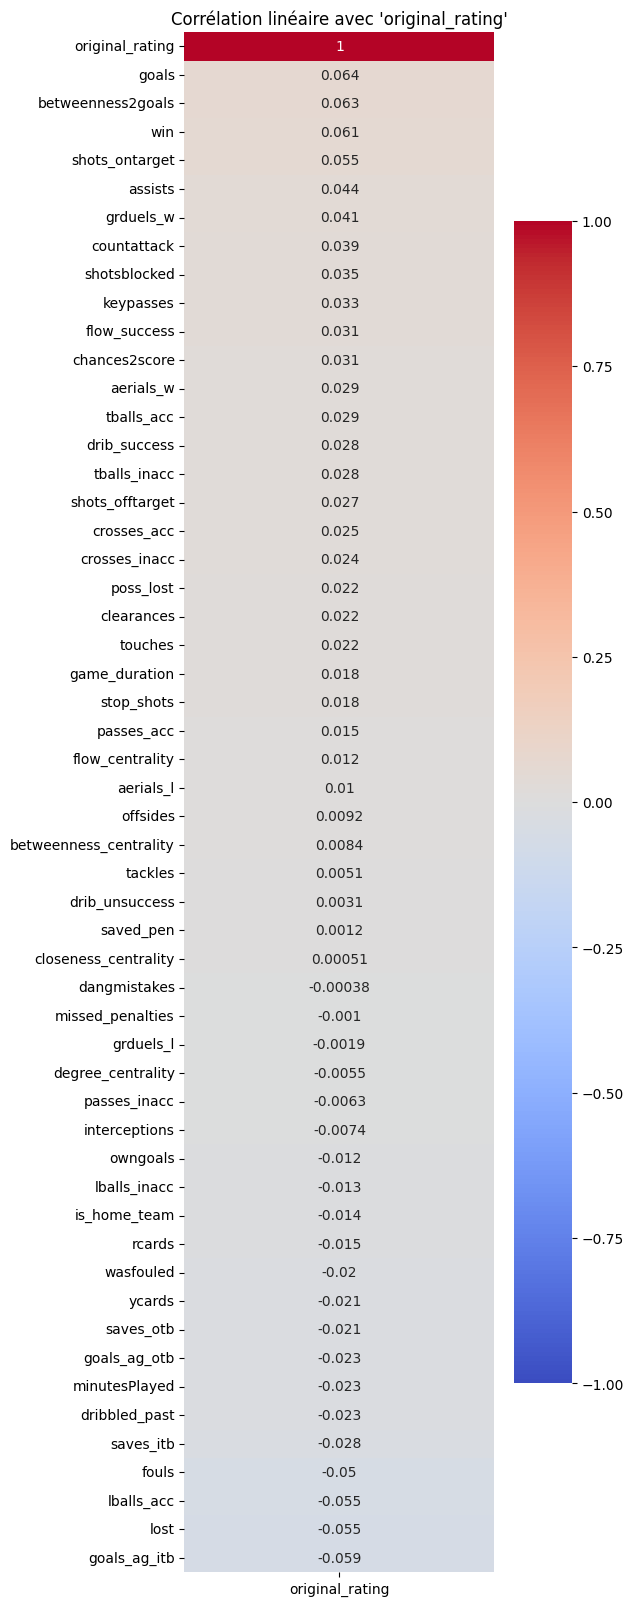

C:\Users\valen\AppData\Local\Temp\ipykernel_26196\2336208243.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')


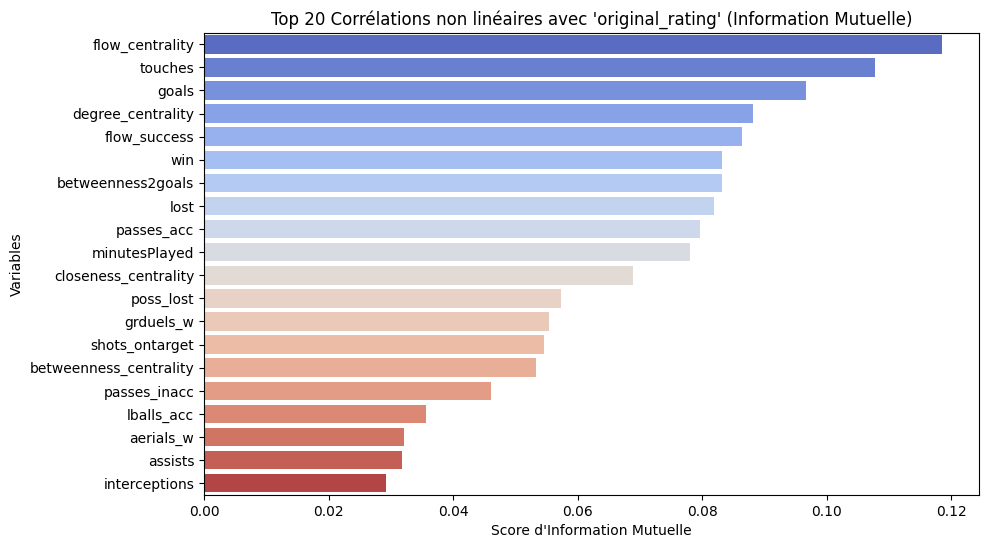

In [103]:
variables = df[[
    "goals",
    "assists",
    "shots_ontarget",
    "shots_offtarget",
    "shotsblocked",
    "chances2score",
    "drib_success",
    "drib_unsuccess",
    "keypasses",
    "touches",
    "passes_acc",
    "passes_inacc",
    "crosses_acc",
    "crosses_inacc",
    "lballs_acc",
    "lballs_inacc",
    "grduels_w",
    "grduels_l",
    "aerials_w",
    "aerials_l",
    "poss_lost",
    "fouls",
    "wasfouled",
    "clearances",
    "stop_shots",
    "interceptions",
    "tackles",
    "dribbled_past",
    "tballs_acc",
    "tballs_inacc",
    "ycards",
    "rcards",
    "dangmistakes",
    "countattack",
    "offsides",
    "goals_ag_otb",
    "goals_ag_itb",
    "saves_itb",
    "saves_otb",
    "saved_pen",
    "missed_penalties",
    "owngoals",
    "degree_centrality",
    "betweenness_centrality",
    "closeness_centrality",
    "flow_centrality",
    "flow_success",
    "betweenness2goals",
    "win",
    "lost",
    "is_home_team",
    "minutesPlayed",
    "game_duration",
    "player",
    "original_rating"
]]

# Exclure la colonne 'player'
df_no_player_a = variables.drop(columns=['player'])

# Calculer la corrélation linéaire (Pearson) entre 'original_rating' et les autres variables
correlation = df_no_player_a.corr()[['original_rating']].sort_values(by='original_rating', ascending=False)

# Créer une heatmap des corrélations linéaires
plt.figure(figsize=(5, 20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title("Corrélation linéaire avec 'original_rating'")
plt.show()

# Calculer la corrélation non linéaire avec l'information mutuelle
X = df_no_player_a.drop(columns=['original_rating'])  # Variables indépendantes
y = df_no_player_a['original_rating']  # Variable cible

# Calculer la corrélation non linéaire avec l'information mutuelle
X = df_no_player_a.drop(columns=['original_rating'])  # Variables indépendantes
y = df_no_player_a['original_rating']  # Variable cible

# Normalisation des données pour éviter les biais
X = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.dtype in ['int64', 'float64'] else x)

# Calculer l'information mutuelle
mi_scores = mutual_info_regression(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

# Sélectionner les 20 variables les plus dépendantes
mi_scores_df = mi_scores_df.head(20)

# Créer un barplot des scores d'information mutuelle
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')
plt.title("Top 20 Corrélations non linéaires avec 'original_rating' (Information Mutuelle)")
plt.xlabel("Score d'Information Mutuelle")
plt.ylabel("Variables")
plt.show()

On sélectionne : ['flow_centrality','goals','win','minutesPlayed']

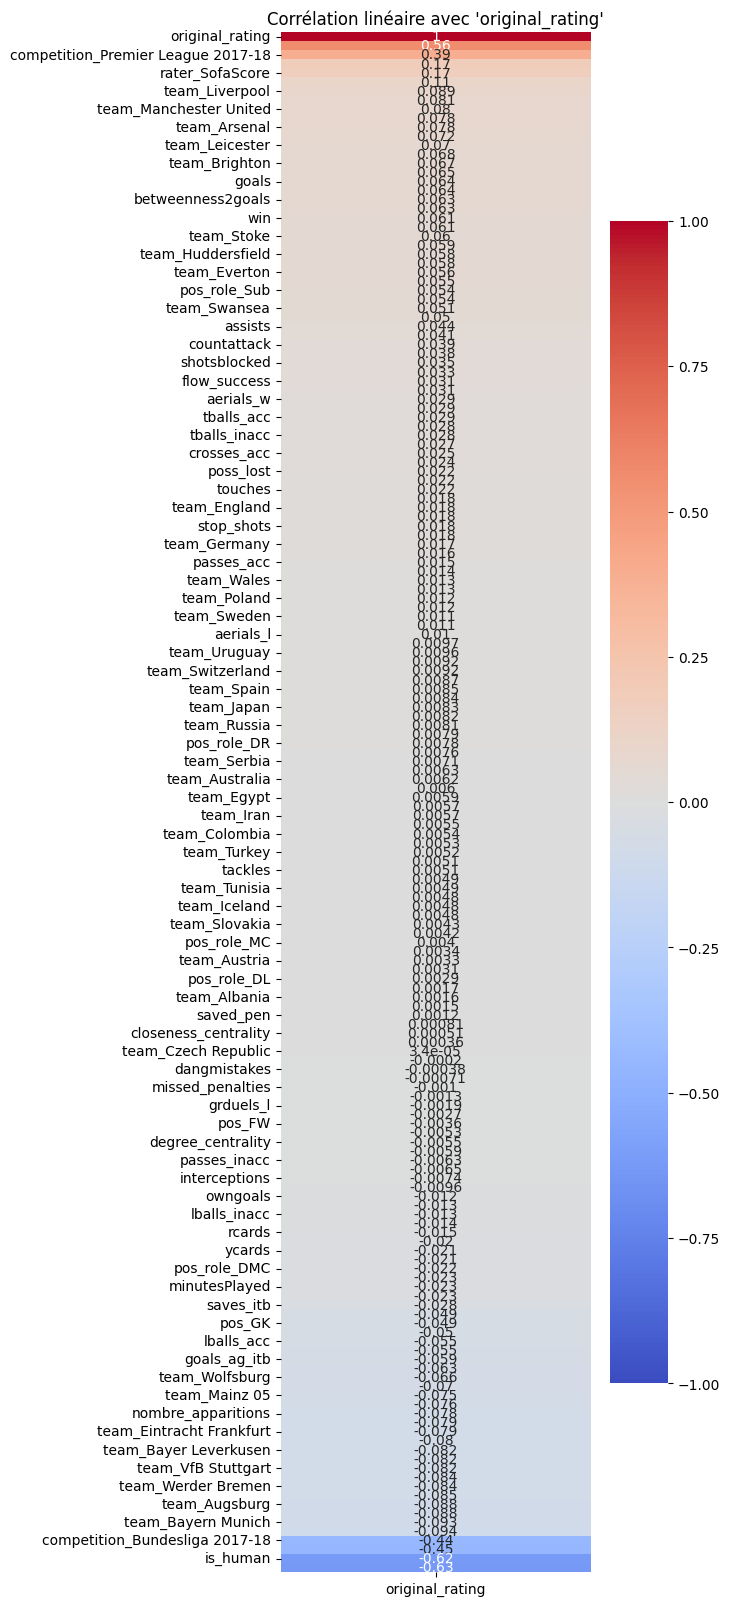

C:\Users\valen\AppData\Local\Temp\ipykernel_26196\617654070.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')


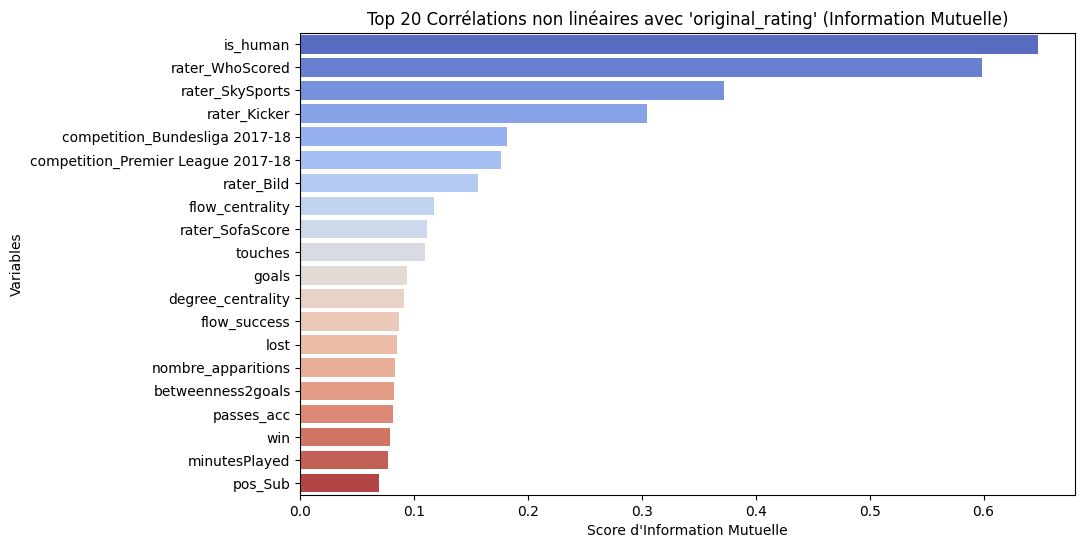

In [102]:
# Exclure la colonne 'player'
df_no_player = df.drop(columns=['player'])

# Calculer la corrélation linéaire (Pearson) entre 'original_rating' et les autres variables
correlation = df_no_player.corr()[['original_rating']].sort_values(by='original_rating', ascending=False)

# Créer une heatmap des corrélations linéaires
plt.figure(figsize=(5, 20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title("Corrélation linéaire avec 'original_rating'")
plt.show()

# Calculer la corrélation non linéaire avec l'information mutuelle
X = df_no_player.drop(columns=['original_rating'])  # Variables indépendantes
y = df_no_player['original_rating']  # Variable cible

# Normalisation des données pour éviter les biais
X = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.dtype in ['int64', 'float64'] else x)

# Calculer l'information mutuelle
mi_scores = mutual_info_regression(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

# Sélectionner les 20 variables les plus dépendantes
mi_scores_df = mi_scores_df.head(20)

# Créer un barplot des scores d'information mutuelle
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')
plt.title("Top 20 Corrélations non linéaires avec 'original_rating' (Information Mutuelle)")
plt.xlabel("Score d'Information Mutuelle")
plt.ylabel("Variables")
plt.show()

Nous allons opter dans un premier temps sur la sélection des variables avec une corrélation supérieur à 0.1 et inférieur à -0,1

Y = df_avg['original_rating'] #Variable continue
X = df_avg[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored','team_Manchester City',#Effets positifs
           'team_Tottenham','team_Liverpool','team_Manchester United','team_Burnley','team_England','team_Southampton',
           'team_Newcastle United','competition_World Cup 2018','team_Arsenal','team_Crystal Palace','rater_SofaScore','team_Leicester','team_Watford',
           'nombre_apparitions','team_Hannover 96','team_Hamburger SV','team_Wolfsburg','team_Schalke 04','team_Bayer Leverkusen','team_VfB Stuttgart',#Effets négatifs
           'team_Augsburg','team_Hertha Berlin','team_RasenBallsport Leipzig','team_Borussia Dortmund','team_Mainz 05','team_Werder Bremen',
           'team_Bayern Munich','team_Freiburg', 'team_Hoffenheim','is_human','rater_Kicker','competition_Bundesliga 2017-18','rater_Bild']]

Y = df['original_rating'] #Variable continue
X = df[['rater_SkySports','competition_Premier League 2017-18','rater_WhoScored','team_Manchester City',#Effets positifs
           'team_Tottenham','team_Liverpool','team_Manchester United','team_Burnley','team_England','team_Southampton',
           'team_Newcastle United','competition_World Cup 2018','team_Arsenal','team_Crystal Palace','rater_SofaScore','team_Leicester','team_Watford',
           'nombre_apparitions','team_Hannover 96','team_Hamburger SV','team_Wolfsburg','team_Schalke 04','team_Bayer Leverkusen','team_VfB Stuttgart',#Effets négatifs
           'team_Augsburg','team_Hertha Berlin','team_RasenBallsport Leipzig','team_Borussia Dortmund','team_Mainz 05','team_Werder Bremen',
           'team_Bayern Munich','team_Freiburg', 'team_Hoffenheim','is_human','rater_Kicker','competition_Bundesliga 2017-18','rater_Bild']]

Il est intéressant d'observer que après regroupement par joueurs avec les notes moyennes, nous retrouvons distribution contenant deux groupes:

-Un groupe avec de meilleurs notes (moyenne à 6)

-Un autre groupe avec de moins bonnes notes (moyenne à 4,8)

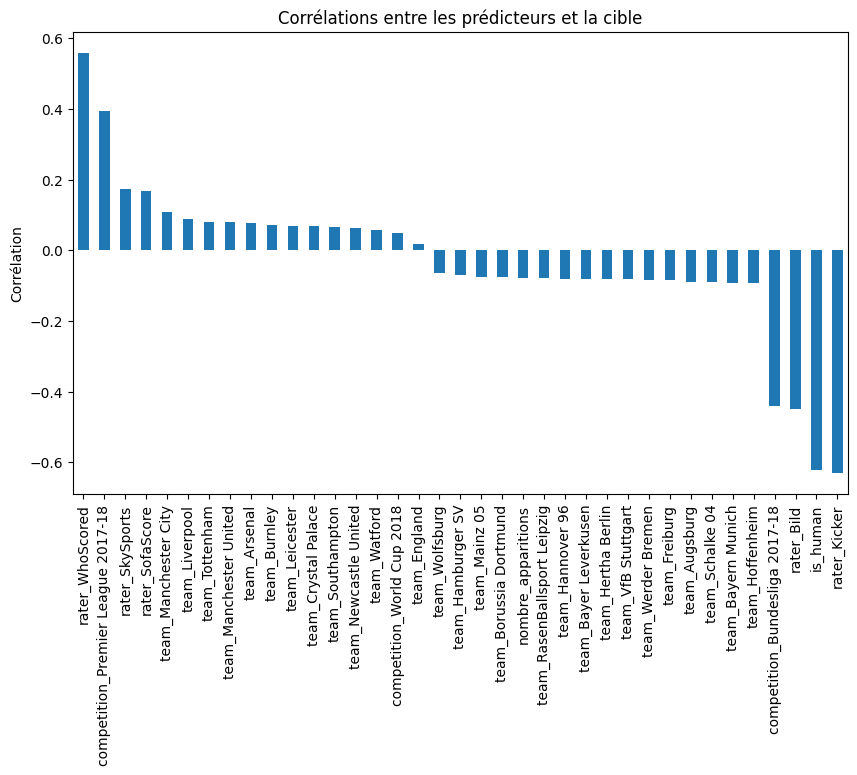

In [ ]:
correlations = X.corrwith(Y).sort_values(ascending=False)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title("Corrélations entre les prédicteurs et la cible")
plt.ylabel("Corrélation")
plt.show()

In [ ]:
'-é

# Elastic Net pour capter l'importance des critères d'annotation pour chaque journaux

In [37]:
df['rater'].unique()

array(['Kicker', 'WhoScored', 'SofaScore', 'TheGuardian', 'SkySports',
       'Bild'], dtype=object)

df_WhoScored = df[df['rater']=='WhoScored'] #is_human = 0

df_SofaScore = df[df['rater']=='SofaScore'] #is_human = 0

df_Kicker = df[df['rater']=='Kicker'] #is_human = 1


df_TheGuardian = df[df['rater']=='TheGuardian'] #is_human = 1

df_SkySports = df[df['rater']=='SkySports'] #is_human = 1

df_Bild = df[df['rater']=='Bild'] #is_human = 1

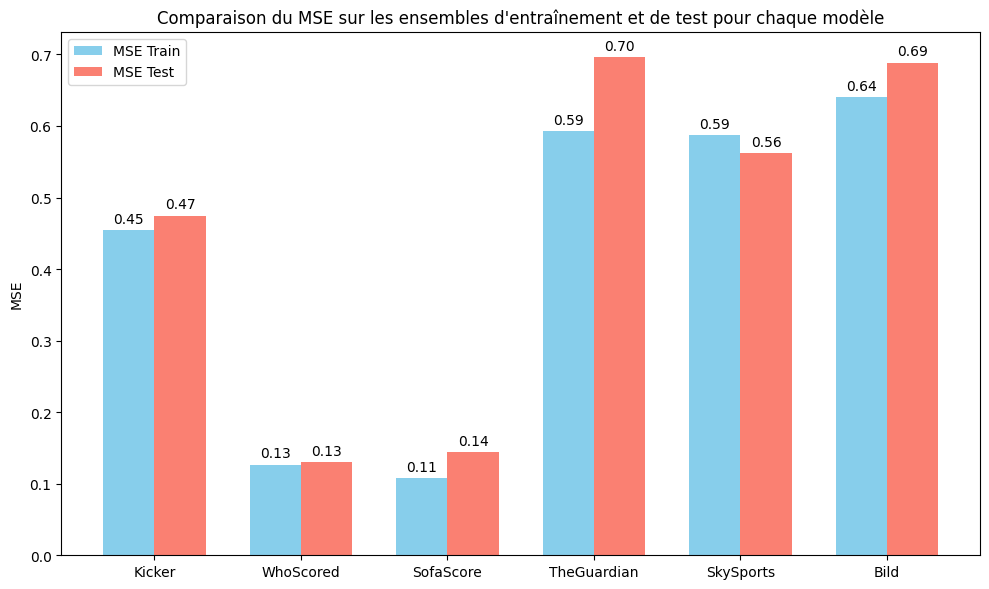

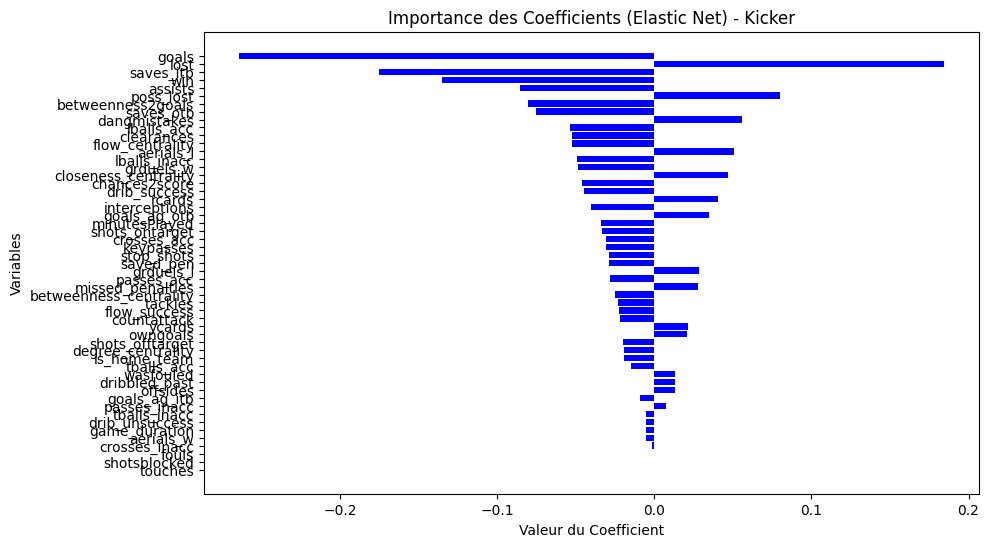

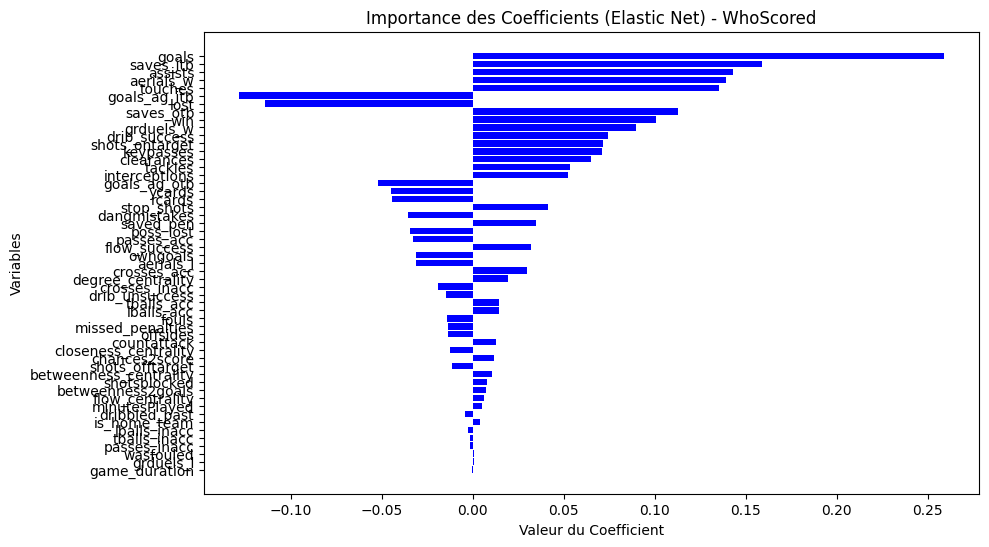

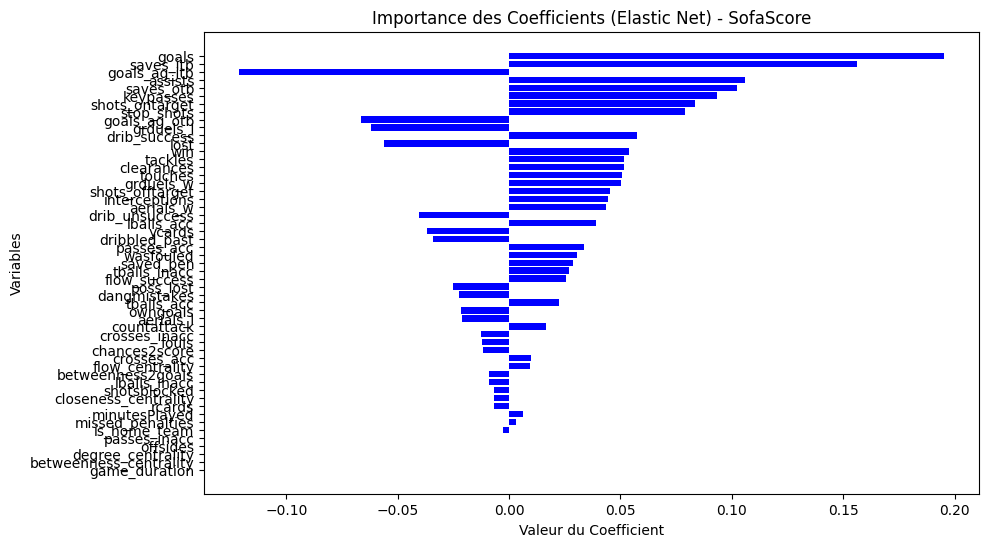

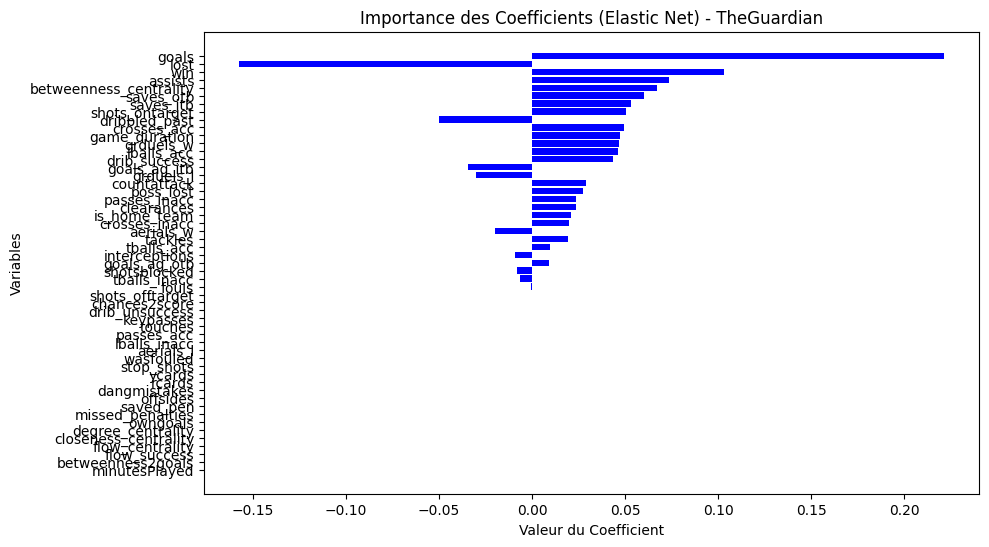

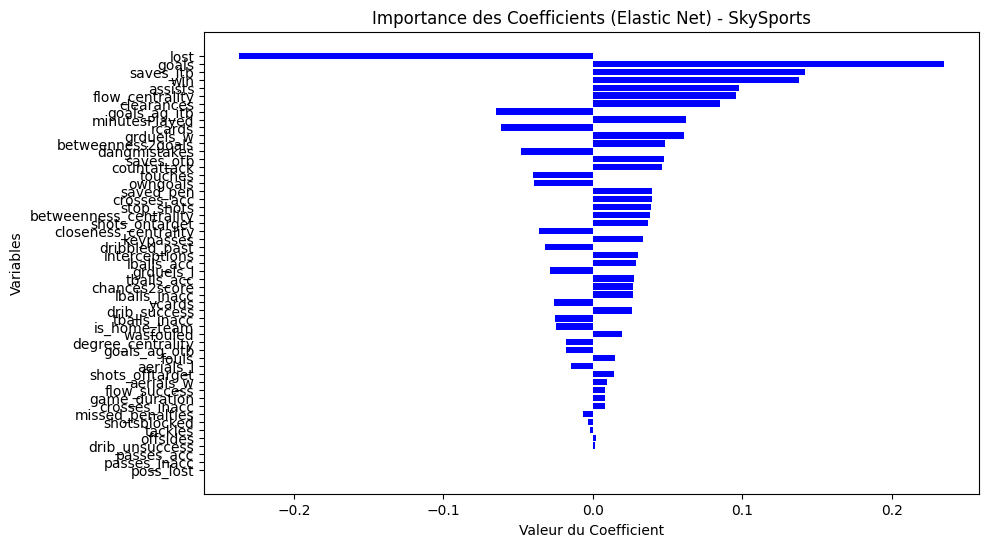

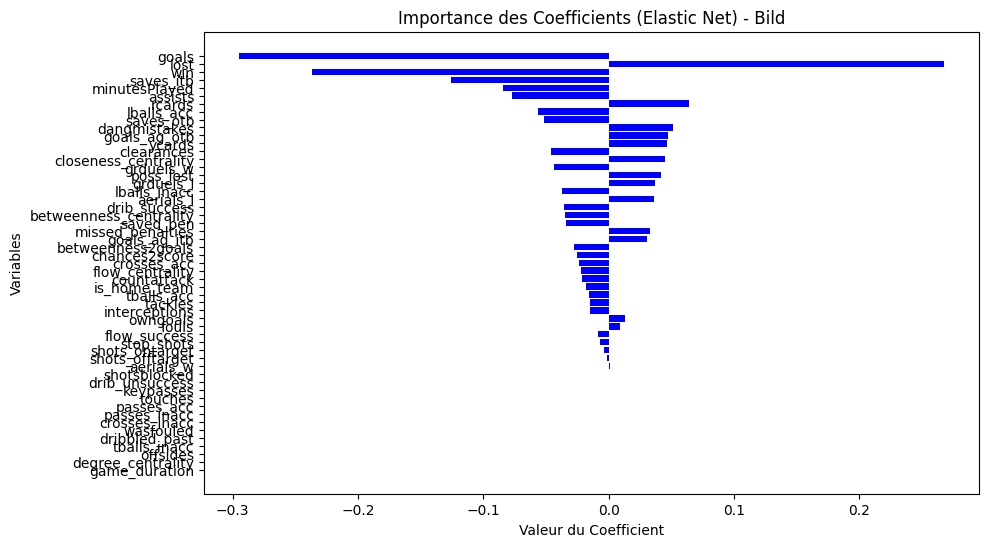

In [87]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# --- Supposons que 'df' est votre DataFrame complet ---

# Liste des sources de notation
raters = ['Kicker', 'WhoScored', 'SofaScore', 'TheGuardian', 'SkySports', 'Bild']

# Dictionnaires pour stocker les résultats
coef_results = {}       # DataFrame avec les coefficients pour chaque modèle
mse_results = {}        # MSE train et test pour chaque modèle
coeff_plots_data = {}   # Liste des coefficients triés pour générer le graphique

# Définition de la grille d'hyperparamètres
param_grid = {
    'alpha': np.logspace(-4, 1, 10),      # Force de régularisation
    'l1_ratio': np.linspace(0.1, 0.9, 9)    # Équilibre entre L1 et L2
}

def process_rater(rater):
    # Sélectionner les données correspondant au rater courant
    df_subset = df[df['rater'] == rater].copy()
    df_subset.drop(columns=['rater'], inplace=True)
    
    # Définition des variables explicatives et de la cible
    X = df_subset[[ 
        "goals", "assists", "shots_ontarget", "shots_offtarget", "shotsblocked",
        "chances2score", "drib_success", "drib_unsuccess", "keypasses", "touches",
        "passes_acc", "passes_inacc", "crosses_acc", "crosses_inacc", "lballs_acc",
        "lballs_inacc", "grduels_w", "grduels_l", "aerials_w", "aerials_l",
        "poss_lost", "fouls", "wasfouled", "clearances", "stop_shots",
        "interceptions", "tackles", "dribbled_past", "tballs_acc", "tballs_inacc",
        "ycards", "rcards", "dangmistakes", "countattack", "offsides",
        "goals_ag_otb", "goals_ag_itb", "saves_itb", "saves_otb", "saved_pen",
        "missed_penalties", "owngoals", "degree_centrality", "betweenness_centrality",
        "closeness_centrality", "flow_centrality", "flow_success", "betweenness2goals",
        "win", "lost", "is_home_team", "minutesPlayed", "game_duration"
    ]]
    Y = df_subset['original_rating']  # Vérifiez que c'est bien la cible souhaitée
    
    # Standardisation des features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Séparation en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)
    
    # Initialisation du modèle ElasticNet et recherche des meilleurs hyperparamètres
    elastic_net = ElasticNet(random_state=42)
    grid_search = GridSearchCV(
        estimator=elastic_net,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=0,
        n_jobs=-1  # Parallélisation dans la recherche d'hyperparamètres
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Récupération des coefficients
    coefficients = best_model.coef_
    feature_names = X.columns
    # Stockage dans un DataFrame trié par ordre décroissant de valeur absolue
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by="Coefficient", key=abs, ascending=False)
    
    # Calculer également une version triée pour le graphique des coefficients
    coef_dict = dict(zip(feature_names, coefficients))
    sorted_coef = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Calcul du MSE sur les ensembles d'entraînement et de test
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    # Affichage optionnel des meilleurs hyperparamètres et des MSE
    print(f"{rater} - Meilleurs hyperparamètres : {grid_search.best_params_}")
    print(f"{rater} - MSE Train : {mse_train:.4f} | MSE Test : {mse_test:.4f}\n")
    
    # Retourner toutes les informations utiles pour ce rater
    return rater, coef_df, mse_train, mse_test, sorted_coef

# Exécution en parallèle sur chacun des raters
results = Parallel(n_jobs=-1)(delayed(process_rater)(rater) for rater in raters)

# Récupération des résultats dans nos dictionnaires
for rater, coef_df, mse_train, mse_test, sorted_coef in results:
    coef_results[rater] = coef_df
    mse_results[rater] = {'MSE_train': mse_train, 'MSE_test': mse_test}
    coeff_plots_data[rater] = sorted_coef

# --- Graphique comparant le MSE sur les ensembles d'entraînement et de test ---

raters_list = list(mse_results.keys())
mse_train_list = [mse_results[rater]['MSE_train'] for rater in raters_list]
mse_test_list = [mse_results[rater]['MSE_test'] for rater in raters_list]

x = np.arange(len(raters_list))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_train = ax.bar(x - width/2, mse_train_list, width, label='MSE Train', color='skyblue')
bars_test = ax.bar(x + width/2, mse_test_list, width, label='MSE Test', color='salmon')

ax.set_ylabel('MSE')
ax.set_title("Comparaison du MSE sur les ensembles d'entraînement et de test pour chaque modèle")
ax.set_xticks(x)
ax.set_xticklabels(raters_list)
ax.legend()

def autolabel(bars):
    """Ajoute une annotation indiquant la valeur sur chaque barre"""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Décalage vertical de 3 points
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars_train)
autolabel(bars_test)

fig.tight_layout()
plt.show()

# --- Graphique des coefficients pour chacun des modèles ---

for rater, sorted_coef in coeff_plots_data.items():
    # Extraire les noms et valeurs des coefficients triés
    features, values = zip(*sorted_coef)
    
    plt.figure(figsize=(10, 6))
    plt.barh(features, values, color="blue")
    plt.xlabel("Valeur du Coefficient")
    plt.ylabel("Variables")
    plt.title(f"Importance des Coefficients (Elastic Net) - {rater}")
    plt.gca().invert_yaxis()  # Inverser l'ordre pour une lecture plus claire
    plt.show()


# En conclusion:

Choix du journal: 

    ['higher_rater','is_human']

Compétition:

    ['competition_Bundesliga 2017-18','competition_World Cup 2018','competition_Premier League 2017-18']
    
Caractéristiques de jeux:

    ['flow_centrality','goals','win','minutesPlayed','nombre_apparitions','Substitute']

    **df['team']

Caractéristiques Temporelles:
    ['year','semester']	

In [89]:
blabla = df[['higher_rater','is_human','flow_centrality','goals','win','minutesPlayed','nombre_apparitions','Substitute','year','semester','competition_Bundesliga 2017-18','competition_World Cup 2018','competition_Premier League 2017-18']]
blabla

,higher_rater,is_human,flow_centrality,goals,win,minutesPlayed,nombre_apparitions,Substitute,year,semester,competition_Bundesliga 2017-18,competition_World Cup 2018,competition_Premier League 2017-18
0,0,1,0.304348,0,0,90,11,0,2016,2,False,False,False
1,1,0,0.304348,0,0,90,11,0,2016,2,False,False,False
2,1,0,0.304348,0,0,90,11,0,2016,2,False,False,False
3,1,0,0.041096,0,1,13,64,1,2016,2,False,False,False
4,0,1,0.347826,0,0,90,7,0,2016,2,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50647,1,1,0.318681,1,0,90,39,0,2018,3,False,True,False
50648,1,0,0.318681,1,0,90,39,0,2018,3,False,True,False
50649,1,0,0.318681,1,0,90,39,0,2018,3,False,True,False
50650,1,1,0.032967,0,0,90,25,1,2018,3,False,True,False
